# Quantitative Metric for LLM perturbation-based Attribution

Our attribution library supports different perturbation and attribution strategies. To provide more context, we'll start by going through the basic outline of a perturbation attribution method:

1. Pass in the desired input and generate an output using it from the LLM we want to study
2. Perturb input tokens by replacing them with 'another' token and capture the new generated output
3. Compare the original output and the perturbed output to 'calculate' the change in the output
4. We assign a high attribution to the input tokens for which the calculated change in output is high and vice versa

The process of selecting another token to perturb input tokens is called a 'perturbation strategy' and the process of calculating the change in output is called an 'attribution strategy'.

We provide support for 2 perturbation strategies:

1. Fixed: This replaces the input token with a fixed token (in this case the `' '` token)
2. NthNearest: This replaces the input token with another token that is n spaces away from it after sorting all other tokens in the vocabulary by distance to the input token being replaced. Here n is a hyperparameter and can range from 1 (the next closest token) to vocabulary size (or -1, the furthest token).

We also provide support for 3 attribution strategies:

1. Cosine: This calculates the cosine similarity between embeddings of the original output and the perturbed output
2. Prob_diff: This calculates the difference in logprobs of the perturbed output and original output tokens
3. Token displacement: This calculates the number of positions the original output token was displaced in the list of logprobs for that token position

In this notebook, we quantitatively measure the performance of these different perturbation and attribution techniques on OpenAI's `gpt-3.5-turbo` model. Since this model can only be accessed by an API, we will be using our `OpenAIAttributor` class. The `OpenAIAttributor` class employs a perturbation-based attribution technique to calculate attribution values.

## Importing Libraries

In [1]:
import os
import sys
import warnings

notebook_path = os.path.abspath(get_ipython().starting_dir)
parent_path = os.path.dirname(notebook_path)

sys.path.append(parent_path)
warnings.simplefilter("ignore")

# Re-import modified modules without restarting the server
%load_ext autoreload
%autoreload 2

In [2]:
from attribution.api_attribution import OpenAIAttributor
from attribution.experiment_logger import ExperimentLogger
from attribution.token_perturbation import (
    FixedPerturbationStrategy,
    NthNearestPerturbationStrategy,
)

## Example Usage of Attribution library

We start off by showing an example of our attribution library to get attribution scores for input tokens corresponding to their importance in generating output tokens. 

We use the string, "Maria is 37 years old today. How many years till she\'s 50?"" in this example. This is actually a carefully crafted input and its significance will be explained in the next section.

__NOTE__: An OpenAI API key is required to use the `OpenAIAttributor` class, which can be generated [here](https://platform.openai.com/api-keys) (assuming an existing OpenAI account). You can either pass your API key to the OpenAIAttributor when you instantiate it, or set it as an environment variable so that our library can access it. for instructions see point 4 [here](https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety).

In [5]:
attributor = OpenAIAttributor()
logger = ExperimentLogger()
attributor.compute_attributions(
    "Maria is 37 years old today. How many years till she's 50?",
    perturbation_strategy=FixedPerturbationStrategy(""),
    attribution_strategies=["prob_diff"],
    logger=logger,
    perturb_word_wise=False,
)
display(logger.df_experiments)
logger.print_sentence_attribution()
logger.print_attribution_matrix(exp_id=1, show_debug_cols=True)

,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,Maria is 37 years old today. How many years ti...,Maria is 13 years away from turning 50.,fixed,False,14.720892


,exp_id,attribution_strategy,perturbation_strategy,perturb_word_wise,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,token_10,token_11,token_12,token_13,token_14,token_15
0,1,prob_diff,fixed,False,Maria 0.78,is 0.15,37 0.34,years -0.02,old 0.14,today -0.02,. -0.00,How 0.32,many -0.01,years 0.28,till 0.28,she -0.02,'s -0.01,50 0.81,? 0.01


Attribution matrix for experiment 1 
Attribution Strategy: prob_diff 
Perturbation strategy: fixed:
Input Tokens (Rows) vs. Output Tokens (Columns)


,Maria (0),is (1),(2),13 (3),years (4),away (5),from (6),turning (7),(8),50 (9),. (10),perturbed_input,perturbed_output
Maria (0),0.967664,0.845934,0.775879,0.140174,0.000171,0.996127,0.999803,0.882030,0.999822,0.999991,0.997351,is 37 years old today. How many years till she's 50?,13 years
is (1),0.162664,-0.064551,-0.223957,-0.080870,0.000311,0.996050,0.008455,0.881052,-0.000014,-0.000003,-0.002565,Maria 37 years old today. How many years till she's 50?,"Maria is currently 37 years old. To calculate how many years until she turns 50, we subtract her current age from 50. 50 - 37 = 13 Therefore, Maria has 13 years until she turns 50."
37 (2),0.300668,-0.107476,-0.223934,0.919128,0.000735,0.996051,0.998410,0.874139,0.000009,0.000107,0.001799,Maria is years old today. How many years till she's 50?,"Maria is currently 25 years old. Therefore, she will turn 50 in 25 years."
years (3),-0.002993,-0.023793,-0.223944,0.044084,-0.000015,-0.000259,-0.000027,-0.023939,-0.000002,0.000002,-0.000072,Maria is 37 old today. How many years till she's 50?,Maria is 13 years away from turning 50.
old (4),0.008930,-0.048341,-0.223958,-0.080871,0.009121,0.995996,0.010120,0.881312,-0.000015,-0.000003,-0.002564,Maria is 37 years today. How many years till she's 50?,"Maria is 37 years old today. To calculate how many years until she turns 50, we subtract her current age from 50. 50 - 37 = 13 Maria has 13 years until she turns 50."
today (5),0.045709,-0.087605,-0.223945,0.016889,-0.000078,0.000166,-0.000060,0.055844,-0.000003,-0.000002,-0.000083,Maria is 37 years old. How many years till she's 50?,Maria is 13 years away from turning 50.
. (6),0.044744,-0.022760,-0.223943,0.194936,0.000082,0.000772,0.000127,-0.022919,-0.000000,-0.000000,0.000034,Maria is 37 years old today How many years till she's 50?,Maria is 13 years away from turning 50.
How (7),0.233013,0.592664,-0.223930,-0.080845,0.111942,0.996127,0.999799,0.882022,0.000012,0.000002,0.001073,Maria is 37 years old today. many years till she's 50?,Maria has 13 years until she turns 50.
many (8),-0.009901,0.028504,-0.223949,0.209685,-0.000041,-0.002051,0.000026,-0.062957,-0.000007,-0.000001,0.002323,Maria is 37 years old today. How years till she's 50?,Maria is 13 years away from turning 50.
years (9),0.012552,0.432098,-0.223950,-0.080844,0.073416,0.996127,0.999645,0.882020,-0.000008,-0.000001,0.000772,Maria is 37 years old today. How many till she's 50?,Maria has 13 years until she turns 50.


## Reasonable Ground Truth

Let's start off by explaining the significance of our chosen input string shown above. The question "Maria is 37 years old today. How many years till she\'s 50?" is special, because in order to answer it correctly, two numbers are _essential_: 37, and 50. This means we can assert that, if the model answers correctly, it _must_ be using those numbers. 

So, the token "13" in the output _should_ be highly attributed to the tokens "37" and "13" in the input, if our attribution methods are good.

In the attribution matrix above we can see that these attribution values are indeed reasonably high.

## Metric calculation

Using the logic from above we can assign *relevant* input and output ids for which to calculate success. Success here is whether or not these relevant input and output ids correspond to high attribution. We define high attribution as higher than the mean attribution for all input tokens for any given output token.

In [6]:
relevant_input_ids = [2, 13]
relevant_output_ids = [3]

perturbation_strategy = "fixed"
exp_id = 1
attribution_strategy = "cosine"

for output_id in relevant_output_ids:
    success = 0
    total = 0
    mean_attr_score = logger.df_token_attribution_matrix[
        (logger.df_token_attribution_matrix["exp_id"] == exp_id)
        & (
            logger.df_token_attribution_matrix["attribution_strategy"]
            == attribution_strategy
        )
        & (logger.df_token_attribution_matrix["output_token_pos"] == output_id)
    ]["attr_score"].mean()
    for input_id in relevant_input_ids:
        attr_score = logger.df_token_attribution_matrix[
            (logger.df_token_attribution_matrix["exp_id"] == exp_id)
            & (
                logger.df_token_attribution_matrix["attribution_strategy"]
                == attribution_strategy
            )
            & (logger.df_token_attribution_matrix["output_token_pos"] == output_id)
            & (logger.df_token_attribution_matrix["input_token_pos"] == input_id)
        ]["attr_score"].item()
        if attr_score > mean_attr_score:
            success += 1
        total += 1

print(
    f"Metric score for perturbation_strategy: {perturbation_strategy} and attribution_strategy: {attribution_strategy} - {success/total}"
)

ValueError: can only convert an array of size 1 to a Python scalar

## Scaling up!

We extend the previous analysis by expanding to 10 crafted questions that share similar characteristics to the one shown above. We also increase the hyperparameters we're assessing:

1. Perturbation strategies: NthNearest - 1,10,100,1000,10000,-1(most distant) and Fixed
2. Attribution strategies: cosine and prob_diff

__NOTE__: Since the output from OpenAI API models is [non-deterministic](https://community.openai.com/t/run-same-query-many-times-different-results/140588/2), there are rare cases when our output ids don't correspond to the generated output correctly. The results shown in this notebook have been captured by ensuring that all the outputs were as expected.

In [19]:
input_strings = [
    "The clock shows 9:47 PM. How many minutes to 10PM?",
    "Maria is 37 years old today. How many years till she's 50?",
    "John has 83 books on his shelf. If he buys 17 more books, how many books will he have in total?",
    "The building is 132 meters tall. How many centimeters tall is the building? No explanation",
    "The package weighs 8.6 kilograms. How many grams does the package weigh?",
    "Jack has 12 teaspoons of sugar. How many tablespoons of sugar does he have?",
    "Alex saved $363 from his birthday gifts. If he spends $45 on a new game, how much money will he have left? No explanation.",
    "The building is 132 meters tall. How many centimeters tall is the building? No explanation.",
    "The thermometer reads 23 degrees Celsius. What is the temperature in Fahrenheit? No explanation.",
    "There are 12 eggs in a dozen. If you use 5 eggs, how many eggs are left?",
]

relevant_input_ids = [
    [3, 5, 12],
    [2, 13],
    [2, 11],
    [3],
    [2],
    [2],
    [3, 13],
    [3],
    [4],
    [2, 11],
]

relevant_output_ids = [[0], [3], [11], [0, 2], [16, 26], [26], [1], [0, 2], [0, 2], [4]]

scores = {}
for i, string in enumerate(input_strings):
    print(f"Calculating attributions for {string}")
    logger = ExperimentLogger()
    attributor = OpenAIAttributor()
    for n in [1, 10, 100, 1000, 10000, -1]:
        attributor.compute_attributions(
            string,
            perturbation_strategy=NthNearestPerturbationStrategy(n),
            attribution_strategies=["cosine", "prob_diff"],
            logger=logger,
            perturb_word_wise=True,
        )

    attributor.compute_attributions(
        string,
        perturbation_strategy=FixedPerturbationStrategy(),
        attribution_strategies=["cosine", "prob_diff"],
        logger=logger,
        perturb_word_wise=True,
    )

    input_ids = relevant_input_ids[i]
    output_ids = relevant_output_ids[i]

    perturbation_strategy = [
        "nth_nearest (n=1)",
        "nth_nearest (n=10)",
        "nth_nearest (n=100)",
        "nth_nearest (n=1000)",
        "nth_nearest (n=10000)",
        "nth_nearest (n=-1)",
        "fixed",
    ]
    for exp_id in range(1, 8):
        for attribution_strategy in ["cosine", "prob_diff"]:
            for output_id in output_ids:
                success = 0
                total = 0
                mean_attr_score = logger.df_token_attribution_matrix[
                    (logger.df_token_attribution_matrix["exp_id"] == exp_id)
                    & (
                        logger.df_token_attribution_matrix["attribution_strategy"]
                        == attribution_strategy
                    )
                    & (
                        logger.df_token_attribution_matrix["output_token_pos"]
                        == output_id
                    )
                ]["attr_score"].mean()
                for input_id in input_ids:
                    attr_score = logger.df_token_attribution_matrix[
                        (logger.df_token_attribution_matrix["exp_id"] == exp_id)
                        & (
                            logger.df_token_attribution_matrix["attribution_strategy"]
                            == attribution_strategy
                        )
                        & (
                            logger.df_token_attribution_matrix["output_token_pos"]
                            == output_id
                        )
                        & (
                            logger.df_token_attribution_matrix["input_token_pos"]
                            == input_id
                        )
                    ]["attr_score"].item()
                    if attr_score > mean_attr_score:
                        success += 1
                    total += 1

            if f"{perturbation_strategy[exp_id-1]}-{attribution_strategy}" in scores:
                scores[f"{perturbation_strategy[exp_id-1]}-{attribution_strategy}"] += (
                    success / total
                )
            else:
                scores[f"{perturbation_strategy[exp_id-1]}-{attribution_strategy}"] = 0
                scores[f"{perturbation_strategy[exp_id-1]}-{attribution_strategy}"] += (
                    success / total
                )

    display(logger.df_experiments)
    # print(f'Metric score for perturbation_strategy: {perturbation_strategy[exp_id-1]} and attribution_strategy: {attribution_strategy} - {success/total}')

Calculating attributions for The clock shows 9:47 PM. How many minutes to 10PM?


KeyboardInterrupt: 

## Plotting results

In [ ]:
import pandas as pd

score_df = {
    "perturbation_strategy": ["-".join(key.split("-")[0:-1]) for key in scores.keys()],
    "attribution_strategy": [key.split("-")[-1] for key in scores.keys()],
    "success": list(scores.values()),
}
score_df = pd.DataFrame(data=score_df, index=[i for i in range(len(scores))])

In [ ]:
score_df

,perturbation_strategy,attribution_strategy,success
0,nth_nearest (n=1),cosine,7.500000
1,nth_nearest (n=1),prob_diff,8.500000
2,nth_nearest (n=1),token_displacement,8.666667
3,nth_nearest (n=10),cosine,6.000000
4,nth_nearest (n=10),prob_diff,7.500000
5,nth_nearest (n=10),token_displacement,6.666667
6,nth_nearest (n=100),cosine,7.166667
7,nth_nearest (n=100),prob_diff,8.666667
8,nth_nearest (n=100),token_displacement,8.166667
9,nth_nearest (n=1000),cosine,7.500000


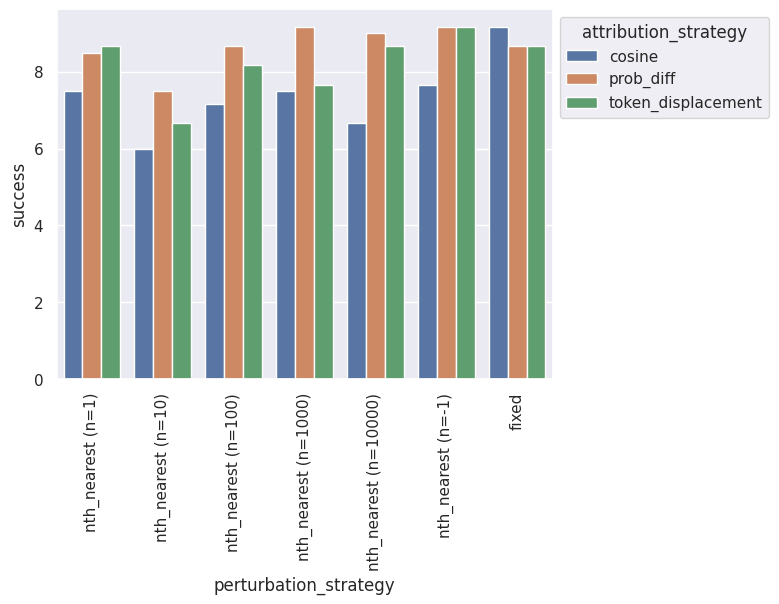

In [ ]:
import seaborn as sns

sns.set_theme()

g = sns.barplot(
    data=score_df, x="perturbation_strategy", y="success", hue="attribution_strategy"
)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

## Conclusion

The maximum success rate i.e. 9.167/10 was achieved by:

- `nth_nearest(n=1000)` perturbation and `prob_diff` attribution
- `nth_nearest(n=-1)` perturbation and `prob_diff` attribution
- `nth_nearest(n=-1)` perturbation attribution
- `fixed` perturbation and `cosine` attribution

There is no clear indication that a single combination of perturbation and attribution strategies is the best. We encourage users to further experiment with these perturbation and attribution strategies along with innovative methods of calculating quantitative metrics to verify our attribution method.

Based on our initial experiment and qualitative analysis, we would recommend using the `fixed` perturbation strategy and the `cosine` attribution strategy for it's relative stability (in the cases we tested) and overall correctness.